In [1130]:
#load libraries
import os
import pandas as pd
import numpy as np
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib_inline
import seaborn as sns
from scipy.sparse import csr_matrix as sparse_matrix
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import NearestNeighbors
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
import warnings
warnings.filterwarnings('ignore')



In [1131]:

# load dataset
df = pd.read_csv(r'C:\Users\berna\lighthouse_data_notes\Final-Project-on-Recommender-System-Online-Retail\online_retail.csv')


In [1132]:
# view dataset
df

,Unnamed: 0,Customer ID,StockCode,Quantity,InvoiceDate,Description
0,59527,16670,21955,2.0,2010-01-18 12:27:00,DOORMAT UNION JACK GUNS AND ROSES
1,51473,17139,21955,10.0,2010-01-11 11:31:00,DOORMAT UNION JACK GUNS AND ROSES
2,51673,15549,21955,5.0,2010-01-11 13:16:00,DOORMAT UNION JACK GUNS AND ROSES
3,67105,15727,21955,2.0,2010-01-24 12:12:00,DOORMAT UNION JACK GUNS AND ROSES
4,74434,15311,21955,10.0,2010-01-29 11:49:00,DOORMAT UNION JACK GUNS AND ROSES
...,...,...,...,...,...,...
824359,913077,17706,23137,6.0,2011-10-10 12:26:00,ZINC WIRE SWEETHEART LETTER TRAY
824360,789214,17706,23137,4.0,2011-07-14 13:41:00,ZINC WIRE SWEETHEART LETTER TRAY
824361,1041795,15444,23137,1.0,2011-11-30 17:37:00,ZINC WIRE SWEETHEART LETTER TRAY
824362,733855,17841,23137,2.0,2011-05-31 14:34:00,ZINC WIRE SWEETHEART LETTER TRAY


In [1133]:
#check for null values
df.isna().sum()

Unnamed: 0     0
Customer ID    0
StockCode      0
Quantity       0
InvoiceDate    0
Description    0
dtype: int64

In [1134]:
# check for datatype
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824364 entries, 0 to 824363
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   824364 non-null  int64  
 1   Customer ID  824364 non-null  int64  
 2   StockCode    824364 non-null  object 
 3   Quantity     824364 non-null  float64
 4   InvoiceDate  824364 non-null  object 
 5   Description  824364 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 37.7+ MB


In [1135]:
# find customer id with Nan
cusid = df[df['Customer ID'].isna()]
cusid#['Customer ID'].values

,Unnamed: 0,Customer ID,StockCode,Quantity,InvoiceDate,Description


In [1136]:
# remove customer id column with Nan
df = df.drop(cusid.index)

In [1137]:
# confirm if na removed
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824364 entries, 0 to 824363
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   824364 non-null  int64  
 1   Customer ID  824364 non-null  int64  
 2   StockCode    824364 non-null  object 
 3   Quantity     824364 non-null  float64
 4   InvoiceDate  824364 non-null  object 
 5   Description  824364 non-null  object 
dtypes: float64(1), int64(2), object(3)
memory usage: 37.7+ MB


In [1138]:
# change customer id from float to integer
df['Customer ID'] = df['Customer ID'].astype(int)

In [1139]:
# change quantity datatype to float
df['Quantity'] = df['Quantity'].astype(float)

In [1140]:
# view dataset
df.head()

,Unnamed: 0,Customer ID,StockCode,Quantity,InvoiceDate,Description
0,59527,16670,21955,2.0,2010-01-18 12:27:00,DOORMAT UNION JACK GUNS AND ROSES
1,51473,17139,21955,10.0,2010-01-11 11:31:00,DOORMAT UNION JACK GUNS AND ROSES
2,51673,15549,21955,5.0,2010-01-11 13:16:00,DOORMAT UNION JACK GUNS AND ROSES
3,67105,15727,21955,2.0,2010-01-24 12:12:00,DOORMAT UNION JACK GUNS AND ROSES
4,74434,15311,21955,10.0,2010-01-29 11:49:00,DOORMAT UNION JACK GUNS AND ROSES


In [1141]:
# check for data quality and accuracy
df[df['StockCode'] == '85048']

,Unnamed: 0,Customer ID,StockCode,Quantity,InvoiceDate,Description
8367,467197,16006,85048,1.0,2010-11-17 12:03:00,15CM CHRISTMAS GLASS BALL 20 LIGHTS
8368,725715,16818,85048,2.0,2011-05-22 15:44:00,15CM CHRISTMAS GLASS BALL 20 LIGHTS
8369,557123,14527,85048,3.0,2010-12-15 12:30:00,15CM CHRISTMAS GLASS BALL 20 LIGHTS
8370,15151,14307,85048,2.0,2009-12-07 13:06:00,15CM CHRISTMAS GLASS BALL 20 LIGHTS
8371,230332,14543,85048,-1.0,2010-06-09 13:55:00,15CM CHRISTMAS GLASS BALL 20 LIGHTS
...,...,...,...,...,...,...
8873,846335,13089,85048,12.0,2011-09-01 11:30:00,15CM CHRISTMAS GLASS BALL 20 LIGHTS
8874,838927,13971,85048,2.0,2011-08-25 14:23:00,15CM CHRISTMAS GLASS BALL 20 LIGHTS
8875,626,16714,85048,-1.0,2009-12-01 11:50:00,15CM CHRISTMAS GLASS BALL 20 LIGHTS
8876,417642,14639,85048,2.0,2010-10-27 13:47:00,15CM CHRISTMAS GLASS BALL 20 LIGHTS


In [1142]:
# check for number of unique product sold
df['StockCode'].nunique()

4646

In [1143]:
# create new dataframe
df_new = df[['Customer ID','StockCode', 'Quantity', 'InvoiceDate', 'Description']].sort_values(by='Description', ascending=True)
df_new

,Customer ID,StockCode,Quantity,InvoiceDate,Description
0,16670,21955,2.0,2010-01-18 12:27:00,DOORMAT UNION JACK GUNS AND ROSES
29,17810,21955,1.0,2010-01-25 10:26:00,DOORMAT UNION JACK GUNS AND ROSES
30,15002,21955,1.0,2010-01-26 11:44:00,DOORMAT UNION JACK GUNS AND ROSES
31,17875,21955,2.0,2010-01-20 15:30:00,DOORMAT UNION JACK GUNS AND ROSES
32,14376,21955,1.0,2010-01-25 15:36:00,DOORMAT UNION JACK GUNS AND ROSES
...,...,...,...,...,...
824345,17812,23137,1.0,2011-11-24 14:06:00,ZINC WIRE SWEETHEART LETTER TRAY
824344,14298,23137,24.0,2011-04-28 10:20:00,ZINC WIRE SWEETHEART LETTER TRAY
824362,17841,23137,2.0,2011-05-31 14:34:00,ZINC WIRE SWEETHEART LETTER TRAY
824352,13012,23137,4.0,2011-11-18 16:13:00,ZINC WIRE SWEETHEART LETTER TRAY


In [1144]:
# save dataframe for visualization
df_new.to_csv('online_retails.csv')

In [1145]:
# data validation
df_new[df_new["StockCode"] == 'SP1002'] 

,Customer ID,StockCode,Quantity,InvoiceDate,Description
363155,17841,SP1002,4.0,2010-10-07 12:23:00,KID'S CHALKBOARD/EASEL
363156,12748,SP1002,1.0,2010-10-07 11:12:00,KID'S CHALKBOARD/EASEL


In [1146]:
# select rows that are not products
rem = ['TEST001',"M","D","TEST002",'BANK CHARGES','C2','CRUK','ADJUST','ADJUST2','DOT','POST', 'Next Day Carriage', 'PACKING CHARGE','PADS']
rem_df = df_new[df_new["StockCode"].isin(rem)]

In [1147]:
# view dataframe
rem_df

,Customer ID,StockCode,Quantity,InvoiceDate,Description
369,16805,BANK CHARGES,1.0,2009-12-08 14:29:00,Bank Charges
370,16928,BANK CHARGES,1.0,2010-02-17 15:03:00,Bank Charges
371,16703,BANK CHARGES,-1.0,2009-12-08 14:08:00,Bank Charges
55201,16422,ADJUST,-1.0,2010-05-24 11:13:00,Adjustment by Peter on 24/05/2010 1
55202,17364,ADJUST,-1.0,2010-05-24 11:13:00,Adjustment by Peter on 24/05/2010 1
...,...,...,...,...,...
749598,12346,TEST001,5.0,2010-01-04 09:53:00,This is a test product.
749597,12346,TEST001,5.0,2009-12-18 10:47:00,This is a test product.
749595,12346,TEST001,5.0,2010-01-04 09:24:00,This is a test product.
749594,16454,TEST001,5.0,2010-04-12 09:52:00,This is a test product.


In [1148]:
# remove the rows from the dataframe
df_new = df_new.drop(rem_df.index)

In [1149]:
# Remove leading whitespace from each string in the column
df_new['Description'] = df_new['Description'].str.strip()
df_new['Description'] = df_new['Description'].str.lstrip()
df_new['Description'] = df_new['Description'].str.rstrip()

In [1150]:
# Remove commas from text
df_new['Description'] = df_new['Description'].str.replace(',', '')

In [1151]:
# link up code with different descriptions for the code
code_desc = df_new[['StockCode', 'Description']]

In [1152]:
# Remove leading whitespace from each string in the column
code_desc['Description'] = code_desc['Description'].str.strip()
code_desc['Description'] = code_desc['Description'].str.lstrip()
code_desc['Description'] = code_desc['Description'].str.rstrip()

In [1153]:
# Identify unique description for the code
code_desc = code_desc.groupby('StockCode')['Description'].apply(','.join).reset_index()

In [1154]:
# view dataframe
code_desc

,StockCode,Description
0,10002,"INFLATABLE POLITICAL GLOBE,INFLATABLE POLITICA..."
1,10080,"GROOVY CACTUS INFLATABLE,GROOVY CACTUS INFLATA..."
2,10109,BENDY COLOUR PENCILS
3,10120,"DOGGY RUBBER,DOGGY RUBBER,DOGGY RUBBER,DOGGY R..."
4,10123C,"HEARTS WRAPPING TAPE,HEARTS WRAPPING TAPE,HEAR..."
...,...,...
4629,90214V,"LETTER ""V"" BLING KEY RING,LETTER ""V"" BLING KEY..."
4630,90214W,"LETTER ""W"" BLING KEY RING,LETTER ""W"" BLING KEY..."
4631,90214Y,"LETTER ""Y"" BLING KEY RING,LETTER ""Y"" BLING KEY..."
4632,90214Z,"LETTER ""Z"" BLING KEY RING,LETTER ""Z"" BLING KEY..."


In [1155]:
# Select the first description to align with the code
code_desc['Description'] = code_desc['Description'].str.split(',').str[0]

In [1156]:
# check for number of unique code and description
print('The number of unique code is:',code_desc['StockCode'].nunique())
print('The number of unique description is:',code_desc['Description'].nunique())

The number of unique code is: 4634
The number of unique description is: 4598


In [1157]:
# Create a new column for count description
code_desc['Count_desc'] = code_desc.groupby('Description')['Description'].transform('count')

In [1158]:
# view 
code_desc = code_desc.sort_values(by='Count_desc', ascending=False)

In [1159]:
# view all rows
pd.set_option("display.max_rows", 100)

In [1161]:
# Identify unique description for the code
match_codes_desc = code_desc.groupby('Description')['StockCode'].apply(','.join).reset_index()
match_codes_desc

,Description,StockCode
0,10 COLOUR SPACEBOY PEN,22418
1,11 PC CERAMIC TEA SET POLKADOT,22139
2,12 ASS ZINC CHRISTMAS DECORATIONS,35962
3,12 COLOURED PARTY BALLOONS,22436
4,12 DAISY PEGS IN WOOD BOX,21448
...,...,...
4593,ZINC T-LIGHT HOLDER STARS SMALL,23144
4594,ZINC TOP 2 DOOR WOODEN SHELF,21275
4595,ZINC WILLIE WINKIE CANDLE STICK,84832
4596,ZINC WIRE KITCHEN ORGANISER,23143


In [1162]:
# Select the first code to align with the description
match_codes_desc['StockCode'] = match_codes_desc['StockCode'].str.split(',').str[0]

In [1163]:
# view table
match_codes_desc

,Description,StockCode
0,10 COLOUR SPACEBOY PEN,22418
1,11 PC CERAMIC TEA SET POLKADOT,22139
2,12 ASS ZINC CHRISTMAS DECORATIONS,35962
3,12 COLOURED PARTY BALLOONS,22436
4,12 DAISY PEGS IN WOOD BOX,21448
...,...,...
4593,ZINC T-LIGHT HOLDER STARS SMALL,23144
4594,ZINC TOP 2 DOOR WOODEN SHELF,21275
4595,ZINC WILLIE WINKIE CANDLE STICK,84832
4596,ZINC WIRE KITCHEN ORGANISER,23143


In [1164]:
# check for number of unique code and description
print('The number of unique code is:',match_codes_desc['StockCode'].nunique())
print('The number of unique description is:',match_codes_desc['Description'].nunique())

The number of unique code is: 4598
The number of unique description is: 4598


In [1165]:
# trim again
match_codes_desc['Description'] = match_codes_desc['Description'].str.strip()

In [1166]:
# view result
match_codes_desc

,Description,StockCode
0,10 COLOUR SPACEBOY PEN,22418
1,11 PC CERAMIC TEA SET POLKADOT,22139
2,12 ASS ZINC CHRISTMAS DECORATIONS,35962
3,12 COLOURED PARTY BALLOONS,22436
4,12 DAISY PEGS IN WOOD BOX,21448
...,...,...
4593,ZINC T-LIGHT HOLDER STARS SMALL,23144
4594,ZINC TOP 2 DOOR WOODEN SHELF,21275
4595,ZINC WILLIE WINKIE CANDLE STICK,84832
4596,ZINC WIRE KITCHEN ORGANISER,23143


In [1167]:
# limit rows to 100
pd.set_option('display.max_rows', 100)

In [1168]:
# Create a dictionary with the stockcode-description for mapping
match_codes_desc_dict = match_codes_desc.set_index('StockCode')['Description'].to_dict()

In [1169]:
# view dictionary
match_codes_desc_dict

{'22418': '10 COLOUR SPACEBOY PEN',
 '22139': '11 PC CERAMIC TEA SET POLKADOT',
 '35962': '12 ASS ZINC CHRISTMAS DECORATIONS',
 '22436': '12 COLOURED PARTY BALLOONS',
 '21448': '12 DAISY PEGS IN WOOD BOX',
 '22282': '12 EGG HOUSE PAINTED WOOD',
 '23442': '12 HANGING EGGS HAND PAINTED',
 '21447': '12 IVORY ROSE PEG PLACE SETTINGS',
 '22906': '12 MESSAGE CARDS WITH ENVELOPES',
 '21440': '12 MINI TOADSTOOL PEGS',
 '20973': '12 PENCIL SMALL TUBE WOODLAND',
 '20976': '12 PENCILS SMALL TUBE POSY',
 '20975': '12 PENCILS SMALL TUBE RED RETROSPOT',
 '20974': '12 PENCILS SMALL TUBE SKULL',
 '20984': '12 PENCILS TALL TUBE POSY',
 '20983': '12 PENCILS TALL TUBE RED RETROSPOT',
 '20982': '12 PENCILS TALL TUBE SKULLS',
 '20981': '12 PENCILS TALL TUBE WOODLAND',
 '84461': '12 PINK HEN+CHICKS IN BASKET',
 '21445': '12 PINK ROSE PEG PLACE SETTINGS',
 '21446': '12 RED ROSE PEG PLACE SETTINGS',
 '84465': '15 PINK FLUFFY CHICKS IN BOX',
 '85048': '15CM CHRISTMAS GLASS BALL 20 LIGHTS',
 '23253': '16 PC CUT

In [1170]:
# trim again
df_new['Description'] = df_new['Description'].str.strip()

In [1171]:
# Map description to new stockcode
df_new['Description'] = df_new['StockCode'].map(match_codes_desc_dict).fillna(df_new['Description'])

In [1172]:
# view cleaned table
df_new

,Customer ID,StockCode,Quantity,InvoiceDate,Description
0,16670,21955,2.0,2010-01-18 12:27:00,DOORMAT UNION JACK GUNS AND ROSES
29,17810,21955,1.0,2010-01-25 10:26:00,DOORMAT UNION JACK GUNS AND ROSES
30,15002,21955,1.0,2010-01-26 11:44:00,DOORMAT UNION JACK GUNS AND ROSES
31,17875,21955,2.0,2010-01-20 15:30:00,DOORMAT UNION JACK GUNS AND ROSES
32,14376,21955,1.0,2010-01-25 15:36:00,DOORMAT UNION JACK GUNS AND ROSES
...,...,...,...,...,...
824345,17812,23137,1.0,2011-11-24 14:06:00,ZINC WIRE SWEETHEART LETTER TRAY
824344,14298,23137,24.0,2011-04-28 10:20:00,ZINC WIRE SWEETHEART LETTER TRAY
824362,17841,23137,2.0,2011-05-31 14:34:00,ZINC WIRE SWEETHEART LETTER TRAY
824352,13012,23137,4.0,2011-11-18 16:13:00,ZINC WIRE SWEETHEART LETTER TRAY


In [1173]:
# check for number of unique code and description
print('The number of unique code is:',df_new['StockCode'].nunique())
print('The number of unique description is:',df_new['Description'].nunique())

The number of unique code is: 4634
The number of unique description is: 4601


In [1174]:
# preprocess to align code to description 
id = df_new[['StockCode', 'Description']]

In [1175]:
# Identify unique description for the code
id = id.groupby('Description')['StockCode'].apply(','.join).reset_index()

In [1176]:
# Create a new column for count description
id['Count_id'] = id.groupby('Description')['Description'].transform('count')

In [1177]:
id = id[['StockCode', 'Description']]

In [1178]:
# Select the first code to align with the description
id['StockCode'] = id['StockCode'].str.split(',').str[0]

In [1179]:
id

,StockCode,Description
0,22418,10 COLOUR SPACEBOY PEN
1,22139,11 PC CERAMIC TEA SET POLKADOT
2,35962,12 ASS ZINC CHRISTMAS DECORATIONS
3,22436,12 COLOURED PARTY BALLOONS
4,21448,12 DAISY PEGS IN WOOD BOX
...,...,...
4596,23144,ZINC T-LIGHT HOLDER STARS SMALL
4597,21275,ZINC TOP 2 DOOR WOODEN SHELF
4598,84832,ZINC WILLIE WINKIE CANDLE STICK
4599,23143,ZINC WIRE KITCHEN ORGANISER


In [1180]:
# check for number of unique code and description
print('The number of unique code is:',id['StockCode'].nunique())
print('The number of unique description is:',id['Description'].nunique())

The number of unique code is: 4599
The number of unique description is: 4601


In [1181]:
# counts how many code asigned to different description
id['counts'] = id.groupby('StockCode')['StockCode'].transform('count')

In [1182]:
# Identify duplicated codes
id[id['counts'] > 1]

,StockCode,Description,counts
667,22832,BROCANTE SHELF WITH HOOKS,2
4065,22832,SWEETHEART WIRE WALL TIDY,2
4342,22433,WATERING CAN GREEN DINOSAUR,2
4343,22433,WATERING CAN PINK BUNNY,2


In [1183]:
# Identify the duplicated codes
id_dup = id[id['counts'] > 1]

In [1184]:
# view the codes
id_dup

,StockCode,Description,counts
667,22832,BROCANTE SHELF WITH HOOKS,2
4065,22832,SWEETHEART WIRE WALL TIDY,2
4342,22433,WATERING CAN GREEN DINOSAUR,2
4343,22433,WATERING CAN PINK BUNNY,2


In [1185]:
# select the first code and description
id_dup = id_dup.drop_duplicates('StockCode', keep='first')

In [1186]:
# view the result
id_dup

,StockCode,Description,counts
667,22832,BROCANTE SHELF WITH HOOKS,2
4342,22433,WATERING CAN GREEN DINOSAUR,2


In [1187]:
# place in a dictionary
id_dup_dict = id_dup.set_index('StockCode')['Description'].to_dict()

In [1188]:
# view dictionary
id_dup_dict

{'22832': 'BROCANTE SHELF WITH HOOKS', '22433': 'WATERING CAN GREEN DINOSAUR'}

In [1190]:
# Identify unique description for the code
id = id.groupby('StockCode')['Description'].apply(','.join).reset_index()

In [1191]:
# Join all description
id[id['StockCode']=='22433']

,StockCode,Description
1614,22433,"WATERING CAN GREEN DINOSAUR,WATERING CAN PINK ..."


In [1192]:
# Select the first code to align with the description
id['Description'] = id['Description'].str.split(',').str[0]

In [1193]:
# view result
id

,StockCode,Description
0,10002,INFLATABLE POLITICAL GLOBE
1,10080,GROOVY CACTUS INFLATABLE
2,10109,BENDY COLOUR PENCILS
3,10120,DOGGY RUBBER
4,10123C,HEARTS WRAPPING TAPE
...,...,...
4594,90214V,"LETTER ""V"" BLING KEY RING"
4595,90214W,"LETTER ""W"" BLING KEY RING"
4596,90214Y,"LETTER ""Y"" BLING KEY RING"
4597,90214Z,"LETTER ""Z"" BLING KEY RING"


In [1194]:
# change to dictionary
id_dict = id.set_index('Description')['StockCode'].to_dict()

In [1195]:
# view result
id_dict

{'INFLATABLE POLITICAL GLOBE': '10002',
 'GROOVY CACTUS INFLATABLE': '10080',
 'BENDY COLOUR PENCILS': '10109',
 'DOGGY RUBBER': '10120',
 'HEARTS WRAPPING TAPE': '10123C',
 'ARMY CAMO WRAPPING TAPE': '10123G',
 'SPOTS ON RED BOOKCOVER TAPE': '10124A',
 'ARMY CAMO BOOKCOVER TAPE': '10124G',
 'MINI FUNKY DESIGN TAPES': '10125',
 'COLOURING PENCILS BROWN TUBE': '10133',
 'ASSORTED COLOUR JUMBO PEN': '10138',
 'ASSTD DESIGN RACING CAR PEN': '11001',
 'FAN BLACK FRAME': '15030',
 'PAPER POCKET TRAVELING FAN': '15034',
 'ASSORTED COLOURS SILK FAN': '15036',
 'SANDALWOOD FAN': '15039',
 'PINK PAPER PARASOL': '15044A',
 'BLUE PAPER PARASOL': '15044B',
 'PURPLE PAPER PARASOL': '15044C',
 'RED PAPER PARASOL': '15044D',
 'EDWARDIAN PARASOL BLACK': '15056BL',
 'EDWARDIAN PARASOL NATURAL': '15056N',
 'EDWARDIAN PARASOL PINK': '15056P',
 'BLUE POLKADOT GARDEN PARASOL': '15058A',
 'PINK POLKADOT GARDEN PARASOL': '15058B',
 'ICE CREAM DESIGN GARDEN PARASOL': '15058C',
 'ENGLISH ROSE EDWARDIAN PARASOL

In [1196]:
# mapping to description column on the table
df_new['StockCode'] = df_new['Description'].map(id_dict).fillna(df_new['Description'])

In [1197]:
# Drop rows with this description
rows_to_drop = ['SWEETHEART WIRE WALL TIDY','WATERING CAN PINK BUNNY']

In [1198]:
# Drop rows where the 'Description' column contains 'rows to drop'
df_new = df_new[~df_new['Description'].str.contains('SWEETHEART WIRE WALL TIDY', na=False)]
df_new = df_new[~df_new['Description'].str.contains('WATERING CAN PINK BUNNY', na=False)]

In [1199]:
# copy table
df_online_sales =  df_new.copy()

In [1200]:
# check for number of unique code and description
print('The number of unique code is:',df_online_sales['StockCode'].nunique())
print('The number of unique description is:',df_online_sales['Description'].nunique())

The number of unique code is: 4599
The number of unique description is: 4599


In [1201]:
# save table as csv
df_online_sales.to_csv('Online_sales.csv')

In [1202]:
# build interaction matrix-User-Item 
matrix = df_new.pivot_table(index='Customer ID', columns = 'Description', values='Quantity')

In [1203]:
# view matrix
matrix

Description,10 COLOUR SPACEBOY PEN,11 PC CERAMIC TEA SET POLKADOT,12 ASS ZINC CHRISTMAS DECORATIONS,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 MINI TOADSTOOL PEGS,...,ZINC METAL HEART DECORATION,ZINC POLICE BOX LANTERN,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
Customer ID,,,,,,,,,,,,,,,,,,,,,
12346,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12347,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12348,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12349,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12350,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18283,11.5,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18284,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
18285,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [1204]:
# drop product with less than 10 customer who bought the product
matrix = matrix.dropna(thresh=10, axis=1).fillna(0)

In [1205]:
# view result
matrix.head()

Description,10 COLOUR SPACEBOY PEN,11 PC CERAMIC TEA SET POLKADOT,12 ASS ZINC CHRISTMAS DECORATIONS,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 MINI TOADSTOOL PEGS,12 PENCIL SMALL TUBE WOODLAND,...,ZINC HEARTS PLANT POT HOLDER,ZINC METAL HEART DECORATION,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
Customer ID,,,,,,,,,,,,,,,,,,,,,
12346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12347,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12348,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12349,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12350,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1206]:
# data validation
df_new[df_new['Customer ID'] == 12350]

,Customer ID,StockCode,Quantity,InvoiceDate,Description
19482,12350,22620,12.0,2011-02-02 16:01:00,4 TRADITIONAL SPINNING TOPS
64508,12350,82580,12.0,2011-02-02 16:01:00,BATHROOM METAL SIGN
84315,12350,20652,12.0,2011-02-02 16:01:00,BLUE POLKADOT LUGGAGE TAG
84364,12350,20615,12.0,2011-02-02 16:01:00,BLUE POLKADOT PASSPORT COVER
136465,12350,21832,12.0,2011-02-02 16:01:00,CHOCOLATE CALCULATOR
138678,12350,21908,12.0,2011-02-02 16:01:00,CHOCOLATE THIS WAY METAL SIGN
417820,12350,22412,12.0,2011-02-02 16:01:00,METAL SIGN NEIGHBOURHOOD WITCH
514889,12350,84086C,6.0,2011-02-02 16:01:00,PINK/PURPLE RETRO RADIO
519114,12350,22551,12.0,2011-02-02 16:01:00,PLASTERS IN TIN SPACEBOY
521550,12350,22557,12.0,2011-02-02 16:01:00,PLASTERS IN TIN VINTAGE PAISLEY


In [1207]:
#creating mean quantity data
quantity = pd.DataFrame(df_new.groupby('Description')["Quantity"].mean())
quantity.rename(columns={'Quantity': 'AvgQuantity'},inplace=True)
quantity.head()

,AvgQuantity
Description,
10 COLOUR SPACEBOY PEN,23.952475
11 PC CERAMIC TEA SET POLKADOT,5.007277
12 ASS ZINC CHRISTMAS DECORATIONS,8.045455
12 COLOURED PARTY BALLOONS,15.501845
12 DAISY PEGS IN WOOD BOX,4.759162


In [1208]:
#creating number of quantity(items) data
quantity['no_of_cust_per_product'] = pd.DataFrame(df_new.groupby('Description')['Quantity'].count())
quantity.head()


,AvgQuantity,no_of_cust_per_product
Description,,
10 COLOUR SPACEBOY PEN,23.952475,505
11 PC CERAMIC TEA SET POLKADOT,5.007277,1924
12 ASS ZINC CHRISTMAS DECORATIONS,8.045455,66
12 COLOURED PARTY BALLOONS,15.501845,271
12 DAISY PEGS IN WOOD BOX,4.759162,191


In [1209]:
# get all customer was purchased at least one item
quantity = quantity[quantity['no_of_cust_per_product'] > 0]

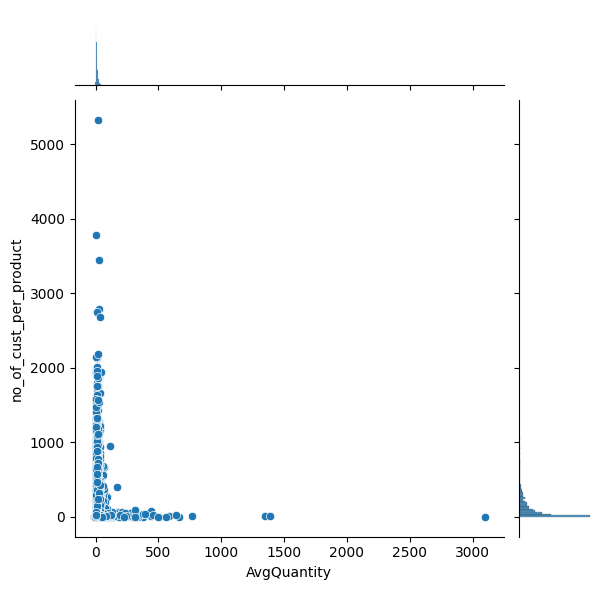

In [1210]:
#plotting the jointplot
sns.jointplot(x='AvgQuantity', y='no_of_cust_per_product', data=quantity)

In [1211]:
# creat most purchased product dataset
quantity.sort_values('no_of_cust_per_product', ascending=False).head(10)

,AvgQuantity,no_of_cust_per_product
Description,,
CREAM HANGING HEART T-LIGHT HOLDER,16.923149,5322
REGENCY CAKESTAND 3 TIER,6.207572,3777
JUMBO BAG RED RETROSPOT,27.210099,3446
ASSORTED COLOUR BIRD ORNAMENT,28.430208,2794
LUNCH BAG RED RETROSPOT,13.577495,2755
PACK OF 72 RETRO SPOT CAKE CASES,33.687570,2679
STRAWBERRY CERAMIC TRINKET BOX,15.896804,2190
LUNCH BAG BLACK SKULL.,11.392411,2161
REX CASH+CARRY JUMBO SHOPPER,1.903256,2150


Making recommendation for similar product

In [1212]:
# Fetching quantity for party bunting
Party_bunting_product = matrix['PARTY BUNTING']

In [1213]:
Party_bunting_product

Customer ID
12346    0.0
12347    0.0
12348    0.0
12349    0.0
12350    0.0
        ... 
18283    0.0
18284    0.0
18285    0.0
18286    0.0
18287    0.0
Name: PARTY BUNTING, Length: 5876, dtype: float64

In [1214]:
# finding the correlation with the product party bunting
similar_to_party_bunting = matrix.corrwith(Party_bunting_product)

In [1215]:
similar_to_party_bunting.head()

Description
10 COLOUR SPACEBOY PEN               0.109609
11 PC CERAMIC TEA SET POLKADOT       0.124916
12 ASS ZINC CHRISTMAS DECORATIONS   -0.006861
12 COLOURED PARTY BALLOONS           0.044773
12 DAISY PEGS IN WOOD BOX            0.038230
dtype: float64

Creating a threshold for minimum number of product quantity

In [1216]:
# creating dataframe to bring in number of all quantity
corr_party_bunting = pd.DataFrame(similar_to_party_bunting, columns=['correlation'])
corr_party_bunting.dropna(inplace=True)
corr_party_bunting.head()

,correlation
Description,
10 COLOUR SPACEBOY PEN,0.109609
11 PC CERAMIC TEA SET POLKADOT,0.124916
12 ASS ZINC CHRISTMAS DECORATIONS,-0.006861
12 COLOURED PARTY BALLOONS,0.044773
12 DAISY PEGS IN WOOD BOX,0.038230


In [1217]:
# joint total of each product to correlation table of Party bunting
corr_party_bunting = corr_party_bunting.join(quantity['no_of_cust_per_product'])
corr_party_bunting.head()

,correlation,no_of_cust_per_product
Description,,
10 COLOUR SPACEBOY PEN,0.109609,505
11 PC CERAMIC TEA SET POLKADOT,0.124916,1924
12 ASS ZINC CHRISTMAS DECORATIONS,-0.006861,66
12 COLOURED PARTY BALLOONS,0.044773,271
12 DAISY PEGS IN WOOD BOX,0.038230,191


In [1218]:
# filter based on selected number of all quantity
corr_party_bunting[corr_party_bunting['no_of_cust_per_product'] > 100].sort_values(by="correlation", ascending=False).head(5)

,correlation,no_of_cust_per_product
Description,,
PARTY BUNTING,1.000000,2144
BUNTING SPOTTY,0.450489,1036
SET/2 RED RETROSPOT TEA TOWELS,0.306724,652
CARD DOLLY GIRL,0.293688,359
PACK OF 6 LARGE FRUIT STRAWS,0.276683,119


In [1219]:
# copy dataframe for Association rules mining with apriori
df_apr = df_new.copy()

In [1220]:
# select product description and customer id for association rules mining and apriori
# items and Users dataframe
desc = df_apr['Description'].groupby(df_apr['Customer ID']).value_counts()
desc

Customer ID  Description                      
12346        MEDIUM CERAMIC TOP STORAGE JAR       2
             DOOR MAT 3 SMILEY CATS               1
             DOOR MAT AIRMAIL                     1
             DOOR MAT BLACK FLOCK                 1
             DOOR MAT FAIRY CAKE                  1
                                                 ..
18287        TOADSTOOL MONEY BOX                  1
             TREE T-LIGHT HOLDER WILLIE WINKIE    1
             WATERMELON BATH SPONGE               1
             WHITE CHRISTMAS STAR DECORATION      1
             WOODEN BOX ADVENT CALENDAR           1
Name: Description, Length: 481313, dtype: int64

In [1221]:
# create items and Users dataframe
desc = pd.DataFrame(desc)
desc.drop(['Description'], axis=1, inplace=True)

In [1222]:
# reset index
desc_df = desc.reset_index()

In [1223]:
# view dataset
desc_df.head()

,Customer ID,Description
0,12346,MEDIUM CERAMIC TOP STORAGE JAR
1,12346,DOOR MAT 3 SMILEY CATS
2,12346,DOOR MAT AIRMAIL
3,12346,DOOR MAT BLACK FLOCK
4,12346,DOOR MAT FAIRY CAKE


In [1224]:
# view the values
desc_df['Description'].values

array(['MEDIUM CERAMIC TOP STORAGE JAR', 'DOOR MAT 3 SMILEY CATS',
       'DOOR MAT AIRMAIL', ..., 'WATERMELON BATH SPONGE',
       'WHITE CHRISTMAS STAR DECORATION', 'WOODEN BOX ADVENT CALENDAR'],
      dtype=object)

In [1225]:
# create function to return all items bought by each customers in a list of lists
def show_all_products(col):
    all_products = []
    for i in desc_df['Customer ID'].unique():
        custid = i
        custid = desc_df[desc_df['Customer ID'] == custid]
        product_list = list(custid['Description'])
        all_products.append(product_list)
    return all_products

In [1226]:
# save in a variable
products_bought = show_all_products(desc_df['Customer ID'])

In [1227]:
# view products_bought by each customer
products_bought

[['MEDIUM CERAMIC TOP STORAGE JAR',
  'DOOR MAT 3 SMILEY CATS',
  'DOOR MAT AIRMAIL',
  'DOOR MAT BLACK FLOCK',
  'DOOR MAT FAIRY CAKE',
  'DOOR MAT FANCY FONT HOME SWEET HOME',
  'DOOR MAT NEW ENGLAND',
  'DOOR MAT RED SPOT',
  'DOOR MAT RESPECTABLE HOUSE',
  'DOOR MAT SPOTTY HOME SWEET HOME',
  'DOOR MAT UNION FLAG',
  'DOOR MAT WELCOME PUPPIES',
  'DOORMAT CHRISTMAS VILLAGE',
  'DOORMAT HOME SWEET HOME BLUE',
  'DOORMAT I LOVE LONDON',
  'DOORMAT MERRY CHRISTMAS RED',
  'DOORMAT PEACE ON EARTH BLUE',
  'DOORMAT UNION JACK GUNS AND ROSES',
  'DOORMAT WELCOME SUNRISE',
  'DOORMAT WELCOME TO OUR HOME',
  'EDWARDIAN PARASOL BLACK',
  'EDWARDIAN PARASOL NATURAL',
  'EDWARDIAN PARASOL PINK',
  'EDWARDIAN PARASOL RED',
  'RED RETROSPOT CHILDRENS UMBRELLA'],
 ['3D DOG PICTURE PLAYING CARDS',
  'AIRLINE BAG VINTAGE JET SET BROWN',
  'ALARM CLOCK BAKELIKE RED',
  'RED TOADSTOOL LED NIGHT LIGHT',
  'ALARM CLOCK BAKELIKE CHOCOLATE',
  'HEART MEASURING SPOONS SMALL',
  'REGENCY CAKESTAND 3 TIER'

In [1228]:
# transform the list into the right format via the TransactionEncoder
te = TransactionEncoder()
te_ary = te.fit(products_bought).transform(products_bought)
df_matrix = pd.DataFrame(te_ary, columns=te.columns_)
df_matrix

,10 COLOUR SPACEBOY PEN,11 PC CERAMIC TEA SET POLKADOT,12 ASS ZINC CHRISTMAS DECORATIONS,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 MINI TOADSTOOL PEGS,...,ZINC METAL HEART DECORATION,ZINC POLICE BOX LANTERN,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5871,True,True,False,False,False,False,False,False,False,False,...,True,False,False,False,False,False,False,False,False,False
5872,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5873,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
5874,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [1229]:
# verify columns
df_matrix.columns

Index(['10 COLOUR SPACEBOY PEN', '11 PC CERAMIC TEA SET POLKADOT',
       '12 ASS ZINC CHRISTMAS DECORATIONS', '12 COLOURED PARTY BALLOONS',
       '12 DAISY PEGS IN WOOD BOX', '12 EGG HOUSE PAINTED WOOD',
       '12 HANGING EGGS HAND PAINTED', '12 IVORY ROSE PEG PLACE SETTINGS',
       '12 MESSAGE CARDS WITH ENVELOPES', '12 MINI TOADSTOOL PEGS',
       ...
       'ZINC METAL HEART DECORATION', 'ZINC POLICE BOX LANTERN',
       'ZINC SWEETHEART SOAP DISH', 'ZINC SWEETHEART WIRE LETTER RACK',
       'ZINC T-LIGHT HOLDER STAR LARGE', 'ZINC T-LIGHT HOLDER STARS SMALL',
       'ZINC TOP  2 DOOR WOODEN SHELF', 'ZINC WILLIE WINKIE  CANDLE STICK',
       'ZINC WIRE KITCHEN ORGANISER', 'ZINC WIRE SWEETHEART LETTER TRAY'],
      dtype='object', length=4599)

In [1230]:
# verify column values
df_matrix['ZINC SWEETHEART WIRE LETTER RACK'].value_counts() # == False]

False    5809
True       67
Name: ZINC SWEETHEART WIRE LETTER RACK, dtype: int64

In [1231]:
# check dimensionality
df_matrix.shape

(5876, 4599)

Training the model and computing the accuracy

In [1232]:
# instantiate model
apriori(df_matrix, min_support=0.07)

,support,itemsets
0,0.160824,(1)
1,0.078285,(12)
2,0.086113,(46)
3,0.076413,(84)
4,0.116746,(107)
...,...,...
229,0.076583,"(2713, 3723)"
230,0.080837,"(2761, 2766)"
231,0.071307,"(3422, 3318)"
232,0.074711,"(4304, 4270)"


In [1233]:
# view support with item names
apriori(df_matrix, min_support=0.07, use_colnames=True)


,support,itemsets
0,0.160824,(11 PC CERAMIC TEA SET POLKADOT)
1,0.078285,(12 PENCILS SMALL TUBE RED RETROSPOT)
2,0.086113,(3 STRIPEY MICE FELTCRAFT)
3,0.076413,(4 TRADITIONAL SPINNING TOPS)
4,0.116746,(6 RIBBONS RUSTIC CHARM)
...,...,...
229,0.076583,"(PACK OF 72 RETRO SPOT CAKE CASES, SET/20 RED ..."
230,0.080837,"(PAPER CHAIN KIT VINTAGE CHRISTMAS, PAPER CHAI..."
231,0.071307,"(ROSES REGENCY TEACUP AND SAUCER, REGENCY CAKE..."
232,0.074711,"(VINTAGE SNAP CARDS, VINTAGE HEADS AND TAILS C..."


The advantage of working with pandas DataFrames is that we can use its convenient features to filter the results. For instance, let's assume we are only interested in itemsets of length 2 that have a support of at least 0.07 threshold. First, we create the frequent itemsets via apriori and add a new column that stores the length of each itemset:

In [1234]:
# items showing market basket analysis
frequent_itemsets = apriori(df_matrix, min_support=0.07, use_colnames=True)
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets

,support,itemsets,length
0,0.160824,(11 PC CERAMIC TEA SET POLKADOT),1
1,0.078285,(12 PENCILS SMALL TUBE RED RETROSPOT),1
2,0.086113,(3 STRIPEY MICE FELTCRAFT),1
3,0.076413,(4 TRADITIONAL SPINNING TOPS),1
4,0.116746,(6 RIBBONS RUSTIC CHARM),1
...,...,...,...
229,0.076583,"(PACK OF 72 RETRO SPOT CAKE CASES, SET/20 RED ...",2
230,0.080837,"(PAPER CHAIN KIT VINTAGE CHRISTMAS, PAPER CHAI...",2
231,0.071307,"(ROSES REGENCY TEACUP AND SAUCER, REGENCY CAKE...",2
232,0.074711,"(VINTAGE SNAP CARDS, VINTAGE HEADS AND TAILS C...",2


Then, we can select the results that satisfy our desired criteria as follows:

In [1235]:
frequent_itemsets[ (frequent_itemsets['length'] == 2) &
                   (frequent_itemsets['support'] >= 0.07) ]

,support,itemsets,length
194,0.085602,"(BAKING SET 9 PIECE RETROSPOT, 11 PC CERAMIC T...",2
195,0.075562,"(60 TEATIME FAIRY CAKE CASES, PACK OF 60 PINK ...",2
196,0.094112,"(PACK OF 72 RETRO SPOT CAKE CASES, 60 TEATIME ...",2
197,0.071307,"(PACK OF 72 RETRO SPOT CAKE CASES, 72 SWEETHEA...",2
198,0.076583,"(CREAM HANGING HEART T-LIGHT HOLDER, ASSORTED ...",2
199,0.070456,"(ASSORTED COLOUR BIRD ORNAMENT, REGENCY CAKEST...",2
200,0.079986,"(BAKING SET 9 PIECE RETROSPOT, BAKING SET SPAC...",2
201,0.075221,"(PACK OF 72 RETRO SPOT CAKE CASES, BAKING SET ...",2
202,0.087304,"(CREAM HANGING HEART T-LIGHT HOLDER, HEART OF ...",2
203,0.086794,"(HEART OF WICKER SMALL, CREAM HANGING HEART T-...",2


Frozensets

Note that the entries in the "itemsets" column are of type frozenset. Since frozensets are sets, the item order does not matter.

In [1236]:
frequent_itemsets['itemsets'].values

array([frozenset({'11 PC CERAMIC TEA SET POLKADOT'}),
       frozenset({'12 PENCILS SMALL TUBE RED RETROSPOT'}),
       frozenset({'3 STRIPEY MICE FELTCRAFT'}),
       frozenset({'4 TRADITIONAL SPINNING TOPS'}),
       frozenset({'6 RIBBONS RUSTIC CHARM'}),
       frozenset({'60 CAKE CASES VINTAGE CHRISTMAS'}),
       frozenset({'60 TEATIME FAIRY CAKE CASES'}),
       frozenset({'72 SWEETHEART FAIRY CAKE CASES'}),
       frozenset({'ALARM CLOCK BAKELIKE RED'}),
       frozenset({'ANTIQUE SILVER T-LIGHT GLASS'}),
       frozenset({'ASSORTED COLOUR BIRD ORNAMENT'}),
       frozenset({'ASSORTED COLOUR MINI CASES'}),
       frozenset({'BAKING SET 9 PIECE RETROSPOT'}),
       frozenset({'BAKING SET SPACEBOY DESIGN'}),
       frozenset({'BATHROOM METAL SIGN'}), frozenset({'BINGO SET'}),
       frozenset({'BLUE 3 PIECE MINI DOTS CUTLERY SET'}),
       frozenset({'BLUE HARMONICA IN BOX'}),
       frozenset({'BUNTING  SPOTTY'}),
       frozenset({'CAKESTAND 3 TIER LOVEHEART'}),
       frozenset

In [1237]:
# Let's check for the items together and their support
frequent_itemsets[ frequent_itemsets['itemsets'] == {'WOODEN FRAME ANTIQUE WHITE', 'WOODEN PICTURE FRAME WHITE FINISH'} ]

,support,itemsets,length
233,0.075391,"(WOODEN FRAME ANTIQUE WHITE, WOODEN PICTURE FR...",2


In [1238]:
# cosine similarity
from sklearn.metrics.pairwise import cosine_similarity

In [1239]:
# create copy of matrix
matrix_cos = matrix.copy()

In [1240]:
# view User-Item interactions
matrix_cos.head()

Description,10 COLOUR SPACEBOY PEN,11 PC CERAMIC TEA SET POLKADOT,12 ASS ZINC CHRISTMAS DECORATIONS,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 MINI TOADSTOOL PEGS,12 PENCIL SMALL TUBE WOODLAND,...,ZINC HEARTS PLANT POT HOLDER,ZINC METAL HEART DECORATION,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
Customer ID,,,,,,,,,,,,,,,,,,,,,
12346,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12347,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12348,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12349,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12350,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [1241]:
# standardize quantity
def standardize(row):
    new_row = (row - row.mean() / row.max() - row.min())
    return new_row

In [1242]:
# apply standardized function
matrix_cos_std = matrix_cos.apply(standardize)

In [1243]:
# using cosine similarity for similar items
item_similarity = cosine_similarity(matrix_cos_std.T)
#item_similarity = np.all(np.isfinite(item_similarity))
#item_similarity = np.any(np.isnan(item_similarity))

In [1244]:
# view cos similarity
item_similarity

array([[ 1.        ,  0.20420216,  0.11277076, ...,  0.25008291,
        -0.00179067,  0.01218018],
       [ 0.20420216,  1.        ,  0.57820964, ...,  0.17867669,
         0.03019991,  0.06031071],
       [ 0.11277076,  0.57820964,  1.        , ...,  0.14840296,
         0.01764311,  0.02055891],
       ...,
       [ 0.25008291,  0.17867669,  0.14840296, ...,  1.        ,
         0.01597954,  0.01784508],
       [-0.00179067,  0.03019991,  0.01764311, ...,  0.01597954,
         1.        ,  0.0624274 ],
       [ 0.01218018,  0.06031071,  0.02055891, ...,  0.01784508,
         0.0624274 ,  1.        ]])

In [1245]:
# put in dataframe for easy usage
item_similarity_df = pd.DataFrame(item_similarity, index=matrix_cos.columns, columns=matrix_cos.columns)

In [1246]:
# Item to item interaction
item_similarity_df.head()

Description,10 COLOUR SPACEBOY PEN,11 PC CERAMIC TEA SET POLKADOT,12 ASS ZINC CHRISTMAS DECORATIONS,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 MINI TOADSTOOL PEGS,12 PENCIL SMALL TUBE WOODLAND,...,ZINC HEARTS PLANT POT HOLDER,ZINC METAL HEART DECORATION,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
Description,,,,,,,,,,,,,,,,,,,,,
10 COLOUR SPACEBOY PEN,1.000000,0.204202,0.112771,0.101967,0.048345,0.017273,0.044633,0.069646,0.006566,0.329002,...,0.006680,0.225780,0.004415,0.048567,0.185741,0.142347,0.176337,0.250083,-0.001791,0.012180
11 PC CERAMIC TEA SET POLKADOT,0.204202,1.000000,0.578210,0.133807,0.098808,0.196424,0.079764,0.150695,0.078403,0.299208,...,0.057997,0.395956,0.028403,0.078997,0.106810,0.107038,0.796661,0.178677,0.030200,0.060311
12 ASS ZINC CHRISTMAS DECORATIONS,0.112771,0.578210,1.000000,0.085556,0.082528,0.018144,0.056567,0.075890,0.047563,0.152991,...,0.057206,0.328893,0.023858,0.063635,0.085438,0.070586,0.621038,0.148403,0.017643,0.020559
12 COLOURED PARTY BALLOONS,0.101967,0.133807,0.085556,1.000000,0.050957,0.005010,0.048330,0.081299,0.033997,0.049712,...,0.000244,0.064625,0.005062,0.027673,0.029191,0.037857,0.123004,0.058402,-0.001247,0.022544
12 DAISY PEGS IN WOOD BOX,0.048345,0.098808,0.082528,0.050957,1.000000,0.005064,0.104249,0.108773,0.149753,0.035428,...,0.011515,0.052176,0.000277,0.034784,0.025178,0.021705,0.104606,0.027069,0.000230,0.041625


In [1247]:
# make recommendations function
def get_similar_items(item_name, no_of_quantity):
    similar_score = item_similarity_df[item_name]*(no_of_quantity)
    similar_score = similar_score.sort_values(ascending=False).head(3)
    return pd.DataFrame(similar_score)

Let us compare both the Correlation matrix and Cosine Similarity used for product recommendation.

In [1248]:
# cosine similarity
get_similar_items('PARTY BUNTING',3.0)

,PARTY BUNTING
Description,
PARTY BUNTING,3.000000
BUNTING SPOTTY,1.399363
PACK OF 6 COCKTAIL PARASOL STRAWS,0.992849


In [1249]:
# Correlation matrix
corr_party_bunting[corr_party_bunting['no_of_cust_per_product'] > 100].sort_values(by="correlation", ascending=False).head(3)

,correlation,no_of_cust_per_product
Description,,
PARTY BUNTING,1.000000,2144
BUNTING SPOTTY,0.450489,1036
SET/2 RED RETROSPOT TEA TOWELS,0.306724,652


Dataframe for recommendation system. Saving the columns showing product code and product description in the product df Dataframe.

In [1250]:
# Dataframe for recommendation system. 
product_df = df_new[['StockCode', 'Description']]

In [1251]:
# view dataset
product_df

,StockCode,Description
0,21955,DOORMAT UNION JACK GUNS AND ROSES
29,21955,DOORMAT UNION JACK GUNS AND ROSES
30,21955,DOORMAT UNION JACK GUNS AND ROSES
31,21955,DOORMAT UNION JACK GUNS AND ROSES
32,21955,DOORMAT UNION JACK GUNS AND ROSES
...,...,...
824345,23137,ZINC WIRE SWEETHEART LETTER TRAY
824344,23137,ZINC WIRE SWEETHEART LETTER TRAY
824362,23137,ZINC WIRE SWEETHEART LETTER TRAY
824352,23137,ZINC WIRE SWEETHEART LETTER TRAY


Cleaning the product description using regex

In [1252]:
# import the regex library and define function to clean the description column
import re
def clean_desc(description):
    return re.sub("[^a-zA-z0-9]", " ", description.lower())


In [1253]:
# apply function to the description column.
product_df['Description'] = product_df['Description'].apply(clean_desc)

In [1254]:
#view
product_df

,StockCode,Description
0,21955,doormat union jack guns and roses
29,21955,doormat union jack guns and roses
30,21955,doormat union jack guns and roses
31,21955,doormat union jack guns and roses
32,21955,doormat union jack guns and roses
...,...,...
824345,23137,zinc wire sweetheart letter tray
824344,23137,zinc wire sweetheart letter tray
824362,23137,zinc wire sweetheart letter tray
824352,23137,zinc wire sweetheart letter tray


In [1255]:
df_online_sales_tab = df_online_sales.copy()

In [1256]:
df_online_sales_tab['Description'] = df_online_sales_tab['Description'].apply(clean_desc)

In [1257]:
df_online_sales_tab.to_csv('Online_sales_Table.csv')

In [1258]:
# import vectorizer and create a tfidf matrix
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(ngram_range=(1,2))

tfidf = vectorizer.fit_transform(product_df['Description'])

In [1259]:
# define and create the search function
def search(description):
    description = clean_desc(description)
    query_vec = vectorizer.transform([description])
    similarity = cosine_similarity(query_vec, tfidf).flatten()
    indices = np.argpartition(similarity, -5)[-5:]
    results = product_df.iloc[indices][::-1]
    return results

In [1260]:
# check the result of the function
search('PARTY BUNTING')

,StockCode,Description
482021,47566,party bunting
483316,47566,party bunting
483315,47566,party bunting
483317,47566,party bunting
483319,47566,party bunting


Building an interactive search box on jupyter notebook

In [1261]:
# import ipywidgets and Python display
import ipywidgets as widgets
from IPython.display import display

In [1262]:
# build interactive search box
product_input = widgets.Text(
    value="ANIMAL STICKERS",
    description = "Product Name:",
    disabled = False
)

product_list = widgets.Output()

def on_type(deploy_df):
    with product_list:
        product_list.clear_output()
        description = product_df["new"]
        if len(description) > 5:
            display(search(description))

product_input.observe(on_type, names='value')
display(product_input, product_list)

Text(value='ANIMAL STICKERS', description='Product Name:')

Output()

In [1263]:
# create dataframe to find similar customers
similarity_df = df_new[['Customer ID', 'StockCode',  'Quantity',  'InvoiceDate']]

In [1264]:
# find similar customers who bought same product
product_id = '16011' #  sample stockcode
similar_customers = similarity_df[(similarity_df['StockCode'] == product_id) & (similarity_df['Quantity'] > 0)]['Customer ID'].unique()

In [1265]:
# view similar customers (Customer ID)
similar_customers

array([15013, 12839, 17245, 15862, 17220, 14003, 13111, 14723, 17188,
       15489, 12748, 14800, 17859, 12621, 14563, 17596, 12473, 14971,
       16595, 13621, 15581, 17365, 17960, 12877, 14458, 15867, 17019,
       14911, 16895, 17364, 17689, 16186, 16488, 17348, 14521, 15679,
       14532, 17984, 15518, 17448, 14598, 14321, 15898, 13588, 15879,
       17974, 14048, 17340, 14963, 16898, 13268, 14342, 12923, 14651,
       14087, 13605, 16370, 18025, 14541, 14913, 17249, 15872, 14293,
       14346, 16903, 16365, 17589, 15506, 17987, 15044, 16767, 15281,
       13898, 16893, 16129, 17190, 17920, 15646, 17033, 15861, 12649,
       13527, 14684])

In [1266]:
# find similar customers based on quantity greater than one mean customer purchase the product
similar_customer_recs = similarity_df[similarity_df['Customer ID'].isin(similar_customers) & (similarity_df['Quantity'] > 0)]

In [1267]:
# view result
similar_customer_recs

,Customer ID,StockCode,Quantity,InvoiceDate
41,14532,21955,2.0,2010-01-31 11:23:00
28,17364,21955,1.0,2010-01-05 16:50:00
7,15898,21955,1.0,2010-01-14 13:03:00
13,15867,21955,3.0,2010-01-22 12:46:00
136,15862,22150,3.0,2009-12-17 11:43:00
...,...,...,...,...
823949,17340,84832,12.0,2011-07-11 14:40:00
823952,14911,84832,12.0,2010-10-03 11:15:00
824075,14911,84832,12.0,2010-10-11 09:18:00
823998,14911,84832,12.0,2010-11-09 14:42:00


Creating recommendation score similar customer divided by the number of customers

In [1268]:
# create recommendation score
similar_customer_recs = similar_customer_recs['StockCode'].value_counts()/len(similar_customer_recs)
similar_customer_recs

22423     0.004332
85123A    0.003812
21034     0.003704
22197     0.003574
21212     0.002968
            ...   
90209A    0.000022
90195A    0.000022
90129E    0.000022
90212C    0.000022
23137     0.000022
Name: StockCode, Length: 3655, dtype: float64

In [1269]:
# filter recommendation score to reduced the customer whose recommendation greater than 0.001
similar_customer_recs = similar_customer_recs[similar_customer_recs > 0.001]

In [1270]:
# view results
similar_customer_recs

22423     0.004332
85123A    0.003812
21034     0.003704
22197     0.003574
21212     0.002968
            ...   
22907     0.001018
22333     0.001018
84029E    0.001018
48173C    0.001018
22150     0.001018
Name: StockCode, Length: 186, dtype: float64

In [1271]:
# find similarity for all customers based on quantity greater than 0
all_customers = similarity_df[(similarity_df['StockCode'].isin(similar_customer_recs.index)) & (similarity_df['Quantity'] > 0)]

In [1272]:
# view results
all_customers

,Customer ID,StockCode,Quantity,InvoiceDate
127,12836,22150,3.0,2009-12-01 14:19:00
128,17606,22150,6.0,2009-12-02 13:32:00
129,14646,22150,12.0,2010-01-26 10:25:00
130,14160,22150,6.0,2010-01-10 12:06:00
131,15002,22150,3.0,2010-01-26 11:44:00
...,...,...,...,...
813089,14032,84077,48.0,2011-05-17 15:25:00
813088,13804,84077,48.0,2011-11-09 12:30:00
813087,15640,84077,96.0,2011-12-05 14:35:00
813086,15727,84077,48.0,2011-11-23 12:36:00


In [1273]:
# create recommendation percentage
all_customer_recs = all_customers['StockCode'].value_counts() / len(all_customers['Customer ID'].unique())

In [1274]:
# get the percentage of all customers who purchased these products
all_customer_recs

85123A    0.946370
22423     0.625684
85099B    0.612915
84879     0.506567
20725     0.488508
            ...   
22562     0.069500
16237     0.065487
21829     0.056184
21830     0.044509
16011     0.021160
Name: StockCode, Length: 186, dtype: float64

In [1275]:
# creating recommendation percentage dataframe
rec_percentages = pd.concat([similar_customer_recs, all_customer_recs], axis=1)
rec_percentages.columns = ['similar', 'all']

In [1276]:
# view results
rec_percentages

,similar,all
22423,0.004332,0.625684
85123A,0.003812,0.946370
21034,0.003704,0.390551
22197,0.003574,0.337833
21212,0.002968,0.484130
...,...,...
22907,0.001018,0.131157
22333,0.001018,0.112915
84029E,0.001018,0.192448
48173C,0.001018,0.086465


In [1277]:
# create recommendation score dataframe
rec_percentages['score'] = rec_percentages['similar'] / rec_percentages['all']
rec_percentages.sort_values(by='score', ascending=False)


,similar,all,score
16011,0.002513,0.021160,0.118748
21830,0.001148,0.044509,0.025794
16237,0.001538,0.065487,0.023485
21829,0.001213,0.056184,0.021591
22562,0.001256,0.069500,0.018077
...,...,...,...
21754,0.001300,0.351879,0.003694
22469,0.001278,0.346406,0.003689
85099B,0.002101,0.612915,0.003428
22386,0.001126,0.333273,0.003380


In [1278]:
# merge recommendation percentage with product datafram
recs_df =  rec_percentages.head(5).merge(product_df, left_index=True, right_on='StockCode')
recs_df.drop_duplicates().sort_values('score', ascending=False)

,similar,all,score,StockCode,Description
528031,0.003574,0.337833,0.010580,22197,popcorn holder
599830,0.003704,0.390551,0.009484,21034,rex cash carry jumbo shopper
583138,0.004332,0.625684,0.006924,22423,regency cakestand 3 tier
464151,0.002968,0.484130,0.006130,21212,pack of 72 retro spot cake cases
164846,0.003812,0.946370,0.004028,85123A,cream hanging heart t light holder


Let's build an interactive recommendation system on jupyter notebook to see how it works!

In [1279]:
# Building a recommendation function
def finding_similar_products(product_id):
    similar_customers = similarity_df[(similarity_df['StockCode'] == product_id) & (similarity_df['Quantity'] > 0)]['Customer ID'].unique()
    similar_customer_recs = similarity_df[similarity_df['Customer ID'].isin(similar_customers) & (similarity_df['Quantity'] > 0)]
    
    similar_customer_recs = similar_customer_recs['StockCode'].value_counts()/len(similar_customer_recs)
    similar_customer_recs = similar_customer_recs[similar_customer_recs > 0.001]

    all_customers = similarity_df[(similarity_df['StockCode'].isin(similar_customer_recs.index)) & (similarity_df['Quantity'] > 0)]
    all_customer_recs = all_customers['StockCode'].value_counts() / len(all_customers['Customer ID'].unique())

    rec_percentages = pd.concat([similar_customer_recs, all_customer_recs], axis=1)
    rec_percentages.columns = ['similar', 'all']

    rec_percentages['score'] = rec_percentages['similar'] / rec_percentages['all']
    rec_percentages.sort_values(by='score', ascending=False)

    recs_df =  rec_percentages.head(5).merge(product_df, left_index=True, right_on='StockCode')[['score', 'StockCode', 'Description']]
    return recs_df.drop_duplicates().sort_values('score', ascending=False)

In [1280]:
# test to see if our function works
finding_similar_products('popcorn holder')

,score,StockCode,Description


In [1281]:
# create interactive recommendation widget
product_name_input = widgets.Text(
    value = 'party bunting',
    description = 'Prod Name',
    disabled = False
)

recommendation_list = widgets.Output()

def on_type(data):
    with recommendation_list:
        recommendation_list.clear_output()
        name = data['new']
        if len(name) > 5:
            results = search(name)
            product_id = results.iloc[0]['StockCode']
            display(finding_similar_products(product_id))

product_name_input.observe(on_type, names='value')

display(product_name_input, recommendation_list) #3 STRIPEY MICE FELTCRAFT

# type in 'party bunting' in the text box to see list of recommendation

Text(value='party bunting', description='Prod Name')

Output()

In [1285]:
cus_14646 = df_online_sales[df_online_sales['Customer ID'] == 14646]
cus_14646

,Customer ID,StockCode,Quantity,InvoiceDate,Description
129,14646,22150,12.0,2010-01-26 10:25:00,3 STRIPEY MICE FELTCRAFT
118,14646,22150,1.0,2009-12-08 16:09:00,3 STRIPEY MICE FELTCRAFT
79,14646,22150,6.0,2010-03-02 10:04:00,3 STRIPEY MICE FELTCRAFT
502,14646,23345,200.0,2011-08-11 16:12:00,DOLLY GIRL BEAKER
488,14646,23345,400.0,2011-10-20 12:03:00,DOLLY GIRL BEAKER
...,...,...,...,...,...
823673,14646,23144,144.0,2011-05-12 10:13:00,ZINC T-LIGHT HOLDER STARS SMALL
824298,14646,84832,192.0,2011-10-21 08:40:00,ZINC WILLIE WINKIE CANDLE STICK
824238,14646,84832,96.0,2011-09-13 11:47:00,ZINC WILLIE WINKIE CANDLE STICK
824100,14646,84832,96.0,2011-10-20 12:03:00,ZINC WILLIE WINKIE CANDLE STICK


In [1292]:
cus_14646['InvoiceDate'].count()

3853

In [1290]:
cus_14646['Quantity'].value_counts()

 96.0      409
 100.0     356
 48.0      273
 144.0     266
 1.0       262
 72.0      260
 24.0      204
 2.0       187
 12.0      162
 120.0     154
 288.0     145
 200.0     108
 192.0     103
 50.0       81
 60.0       70
 36.0       67
 16.0       58
 240.0      54
 64.0       52
 216.0      45
 32.0       44
 40.0       43
 128.0      38
 10.0       30
 8.0        28
 20.0       26
 108.0      24
 80.0       23
 4.0        22
 300.0      20
 256.0      18
 6.0        18
 30.0       17
 400.0      16
 18.0       14
 320.0      13
 3.0        13
 160.0      13
 384.0      13
 576.0       9
 432.0       9
 480.0       8
 360.0       6
 180.0       5
 25.0        5
 5.0         4
 448.0       3
-1.0         3
-18.0        3
 640.0       2
 720.0       2
-144.0       2
 150.0       2
-72.0        2
 1440.0      2
 176.0       2
-300.0       2
-100.0       2
-22.0        1
 250.0       1
-6.0         1
 92.0        1
-10.0        1
 312.0       1
 9.0         1
-2.0         1
 14.0     